In [1]:
import numpy as np
import scipy.sparse as scpsp
import tqdm
from clutils import *
import pyopencl.array as ca
import os
os.environ["PYOPENCL_CTX"] = "0"
import matplotlib.pyplot as plt

In [2]:
def get_n_excitations(x):
    data_diff = np.diff(x > -1, append=False, axis=0)
    n_excitations = np.ceil(data_diff.sum(axis=0)/2)
    return n_excitations

In [3]:
def run_sims(dist, gamma_range):
        nsims = np.int32(len(gamma_range))
        # create global and local connectivity
        gc_mat = scpsp.csr_matrix([[0,1],[1,0]]).astype('f') 
        lc_mat = scpsp.csr_matrix([[0,1],[1,0]]).astype('f')
        gc_dist_mat = scpsp.csr_matrix([[0,1],[1,0]]).astype('f') * dist
        lc_dist_mat = lc_mat.copy() # irrelevant
        nvtx = np.int32(lc_mat.shape[0])

        # some parameters
        dt = np.float32(0.1)

        # prepare extra info for delays
        local_velocity = 6 # # Salami et al. 2002, intra-cortical conduction 10x slower 
        v2v_velocity = 6 #3.9 # according to Lemarechal et al. 2022
        igc = (gc_dist_mat / local_velocity / dt).astype('i') # rounds down
        ilc = (lc_dist_mat / v2v_velocity / dt).astype('i')

        nh = np.max([igc.max(), ilc.max()])
        nh += 1 # add one to buffer 0 delay state
        # round up to the next power of 2
        nh = (2**np.ceil(np.log2(nh))).astype('i')

        util = Util()
        util.load_kernel('./delays_sparse_buf.opencl.c', 'delays1')
        util.load_kernel('./delays_sparse_buf.opencl.c', 'upbuf_heavi')
        util.load_kernel('./heun_determ.opencl.c', 'heun_pred_determ', 'heun_corr_determ')
        util.load_kernel('./epi2d.opencl.c', 'epi2d_dfun')
        util.init_vectors('xi zi lc1 lc2 gc1 gc2 dx1 dx2 dz1 dz2', (nvtx * nsims,))

        # initialise sparse buffer
        # initialised with zeros, as if in the past the state was below the heaviside thershold "theta"
        util.init_vectors('xbuf', (nh * nvtx * nsims,)) 

        # initialise on fixed point
        x = np.ones((nvtx*nsims,),'f') * -1.337896365956364
        z = np.ones((nvtx*nsims,),'f') * -0.18514344764362828
        # but one vertex below fixed point to trigger one excitation
        z[:nsims] = -0.3
        util.move(x=x, z=z)

        # set all vertices in excitable regime, won't oscillate on its own
        x_0 = np.ones((nvtx*nsims,),'f') * -1.291610504045457 
        util.move(x_0=x_0)

        # move connecitivty and delay informaiton to GPU
        util.move_csr(gc_mat=gc_mat, lc_mat=lc_mat)
        util.move(igc=igc.data,    ilc=ilc.data)

        # set coupling strength
        k_lc = np.zeros((nvtx*nsims,),'f')
        k_gc = np.tile(gamma_range, nvtx)
        util.move(k_lc = k_lc, k_gc=k_gc)

        # local parameters
        I=np.float32(1.0)
        eps=np.float32(0.04)
        theta=np.float32(0.0)

        # handle boilerplate for kernel launches
        def do(f, *args):
                args = [(arg.data if hasattr(arg, 'data') else arg) for arg in args]
                f(util.queue, (nvtx * nsims,), ( nsims,), *args)

        def step(t):
                if t % 2 == 0:
                        
                        do(util.upbuf_heavi, nvtx, nsims, np.int32(t), theta, nh, util.xbuf, util.x)

                        # global coupling for heun corrector, i.e. t+1
                        do(util.delays1, 
                                nvtx, nsims, np.int32(t+1), nh, 
                                util.gc1, util.xbuf, 
                                util.gc_mat_data, util.igc, util.gc_mat_indices, util.gc_mat_indptr,)
                        
                        # local coupling for heun corrector, i.e. t+1
                        do(util.delays1, 
                                nvtx, nsims, np.int32(t+1), nh, 
                                util.lc1, util.xbuf, 
                                util.lc_mat_data, util.ilc, util.lc_mat_indices, util.lc_mat_indptr) 
                        
                        # predictor stage
                        do(util.epi2d_dfun,
                                util.dx1, util.dz1, util.x, util.z, util.x_0, util.k_lc, util.lc2, util.k_gc, util.gc2, eps, I)
                        do(util.heun_pred_determ, dt, util.xi, util.x, util.dx1)
                        do(util.heun_pred_determ, dt, util.zi, util.z, util.dz1)
                        
                        # corrector stage
                        do(util.epi2d_dfun,
                                util.dx2, util.dz2, util.xi, util.zi, util.x_0, util.k_lc, util.lc1, util.k_gc, util.gc1, eps, I)
                        do(util.heun_corr_determ, dt, util.x, util.x, util.dx1, util.dx2)
                        do(util.heun_corr_determ, dt, util.z, util.z, util.dz1, util.dz2)
                else :
                        do(util.upbuf_heavi, nvtx, nsims, np.int32(t), theta, nh, util.xbuf, util.x)
                        # global coupling for heun corrector, i.e. t+1
                        do(util.delays1, 
                                nvtx, nsims, np.int32(t+1), nh, 
                                util.gc2, util.xbuf, 
                                util.gc_mat_data, util.igc, util.gc_mat_indices, util.gc_mat_indptr,)
                        
                        # local coupling for heun corrector, i.e. t+1
                        do(util.delays1, 
                                nvtx, nsims, np.int32(t+1), nh, 
                                util.lc2, util.xbuf, 
                                util.lc_mat_data, util.ilc, util.lc_mat_indices, util.lc_mat_indptr) 
                        
                        # predictor stage
                        do(util.epi2d_dfun,
                                util.dx1, util.dz1, util.x, util.z, util.x_0, util.k_lc, util.lc1, util.k_gc, util.gc1, eps, I)
                        do(util.heun_pred_determ, dt, util.xi, util.x, util.dx1)
                        do(util.heun_pred_determ, dt, util.zi, util.z, util.dz1)
                        
                        # corrector stage
                        do(util.epi2d_dfun,
                                util.dx2, util.dz2, util.xi, util.zi, util.x_0, util.k_lc, util.lc2, util.k_gc, util.gc2, eps, I)
                        do(util.heun_corr_determ, dt, util.x, util.x, util.dx1, util.dx2)
                        do(util.heun_corr_determ, dt, util.z, util.z, util.dz1, util.dz2)

        nskip = 10
        niter = 10000
        x_trace = np.zeros((niter//nskip, nvtx*nsims),'f')
        for i in tqdm.trange(niter):
                step(i)
                if i % nskip == 0:
                        util.x.get_async(util.queue, x_trace[i//nskip])

        n_excitations = get_n_excitations(x_trace)  
        return n_excitations

In [4]:
# small parameter sweep
distance_range = np.arange(40,150.1,5,'f')
gamma_gc_range = np.arange(0.04, 0.2, 0.0005,'f')
n_excitations = np.zeros((len(distance_range),len(gamma_gc_range)*2))
for i,d in enumerate(distance_range):
    n_excitations[i,:] = run_sims(d, gamma_gc_range)


<pyopencl.Context at 0x56361a2807a0 on <pyopencl.Device 'Quadro RTX 4000' on 'NVIDIA CUDA' at 0x56361a164d80>>


100%|██████████| 10000/10000 [00:04<00:00, 2041.14it/s]


<pyopencl.Context at 0x56361b2ba3c0 on <pyopencl.Device 'Quadro RTX 4000' on 'NVIDIA CUDA' at 0x56361a164d80>>


100%|██████████| 10000/10000 [00:04<00:00, 2068.48it/s]


<pyopencl.Context at 0x56361a1b4cf0 on <pyopencl.Device 'Quadro RTX 4000' on 'NVIDIA CUDA' at 0x56361a164d80>>


100%|██████████| 10000/10000 [00:04<00:00, 2059.32it/s]


<pyopencl.Context at 0x56361a077bf0 on <pyopencl.Device 'Quadro RTX 4000' on 'NVIDIA CUDA' at 0x56361a164d80>>


100%|██████████| 10000/10000 [00:04<00:00, 2043.64it/s]


<pyopencl.Context at 0x56361a8fc310 on <pyopencl.Device 'Quadro RTX 4000' on 'NVIDIA CUDA' at 0x56361a164d80>>


100%|██████████| 10000/10000 [00:04<00:00, 2054.06it/s]


<pyopencl.Context at 0x56361a2807a0 on <pyopencl.Device 'Quadro RTX 4000' on 'NVIDIA CUDA' at 0x56361a164d80>>


100%|██████████| 10000/10000 [00:04<00:00, 2035.64it/s]


<pyopencl.Context at 0x56361a077bf0 on <pyopencl.Device 'Quadro RTX 4000' on 'NVIDIA CUDA' at 0x56361a164d80>>


100%|██████████| 10000/10000 [00:04<00:00, 2034.41it/s]


<pyopencl.Context at 0x56361ad1b4c0 on <pyopencl.Device 'Quadro RTX 4000' on 'NVIDIA CUDA' at 0x56361a164d80>>


100%|██████████| 10000/10000 [00:04<00:00, 2039.94it/s]


<pyopencl.Context at 0x56361a1b4cf0 on <pyopencl.Device 'Quadro RTX 4000' on 'NVIDIA CUDA' at 0x56361a164d80>>


100%|██████████| 10000/10000 [00:04<00:00, 2050.70it/s]


<pyopencl.Context at 0x56361a1bf050 on <pyopencl.Device 'Quadro RTX 4000' on 'NVIDIA CUDA' at 0x56361a164d80>>


100%|██████████| 10000/10000 [00:04<00:00, 2045.04it/s]


<pyopencl.Context at 0x56361a1b4cf0 on <pyopencl.Device 'Quadro RTX 4000' on 'NVIDIA CUDA' at 0x56361a164d80>>


100%|██████████| 10000/10000 [00:04<00:00, 2068.42it/s]


<pyopencl.Context at 0x56361a2807a0 on <pyopencl.Device 'Quadro RTX 4000' on 'NVIDIA CUDA' at 0x56361a164d80>>


100%|██████████| 10000/10000 [00:04<00:00, 2028.35it/s]


<pyopencl.Context at 0x56361b0462e0 on <pyopencl.Device 'Quadro RTX 4000' on 'NVIDIA CUDA' at 0x56361a164d80>>


100%|██████████| 10000/10000 [00:04<00:00, 2054.62it/s]


<pyopencl.Context at 0x56361a1bf050 on <pyopencl.Device 'Quadro RTX 4000' on 'NVIDIA CUDA' at 0x56361a164d80>>


100%|██████████| 10000/10000 [00:04<00:00, 2041.94it/s]


<pyopencl.Context at 0x56361a1b4cf0 on <pyopencl.Device 'Quadro RTX 4000' on 'NVIDIA CUDA' at 0x56361a164d80>>


100%|██████████| 10000/10000 [00:04<00:00, 2042.45it/s]


<pyopencl.Context at 0x56361a2807a0 on <pyopencl.Device 'Quadro RTX 4000' on 'NVIDIA CUDA' at 0x56361a164d80>>


100%|██████████| 10000/10000 [00:04<00:00, 2036.54it/s]


<pyopencl.Context at 0x56361a077bf0 on <pyopencl.Device 'Quadro RTX 4000' on 'NVIDIA CUDA' at 0x56361a164d80>>


100%|██████████| 10000/10000 [00:04<00:00, 2043.28it/s]


<pyopencl.Context at 0x56361a2807a0 on <pyopencl.Device 'Quadro RTX 4000' on 'NVIDIA CUDA' at 0x56361a164d80>>


100%|██████████| 10000/10000 [00:04<00:00, 2045.14it/s]


<pyopencl.Context at 0x56361a6704d0 on <pyopencl.Device 'Quadro RTX 4000' on 'NVIDIA CUDA' at 0x56361a164d80>>


100%|██████████| 10000/10000 [00:04<00:00, 2045.64it/s]


<pyopencl.Context at 0x56361a1bf050 on <pyopencl.Device 'Quadro RTX 4000' on 'NVIDIA CUDA' at 0x56361a164d80>>


100%|██████████| 10000/10000 [00:04<00:00, 2032.96it/s]


<pyopencl.Context at 0x56361a1b0bb0 on <pyopencl.Device 'Quadro RTX 4000' on 'NVIDIA CUDA' at 0x56361a164d80>>


100%|██████████| 10000/10000 [00:04<00:00, 2037.12it/s]


<pyopencl.Context at 0x56361a66d3c0 on <pyopencl.Device 'Quadro RTX 4000' on 'NVIDIA CUDA' at 0x56361a164d80>>


100%|██████████| 10000/10000 [00:04<00:00, 2066.14it/s]


<pyopencl.Context at 0x56361a1b0bb0 on <pyopencl.Device 'Quadro RTX 4000' on 'NVIDIA CUDA' at 0x56361a164d80>>


100%|██████████| 10000/10000 [00:04<00:00, 2040.49it/s]


/tmp/ipykernel_40537/898046494.py:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(distance_range, gamma_gc_range, n_excitations[:,:len(gamma_gc_range)].T)


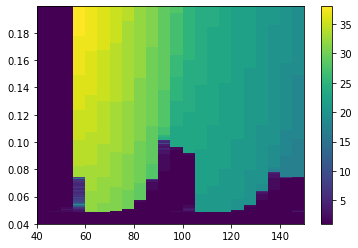

In [6]:
plt.pcolormesh(distance_range, gamma_gc_range, n_excitations[:,:len(gamma_gc_range)].T)
plt.colorbar()

In [7]:
np.savez_compressed("n_excitaions_sweep_two_nodes_gpu", n_excitations=n_excitations, distance_range=distance_range, gamma_gc_range=gamma_gc_range)